In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
#Importing Required Libraries LSTM
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Conv1D
import time

from sklearn.decomposition import PCA

In [4]:
from pyspark.sql import functions as sf

In [5]:
import joblib
from sklearn.decomposition import PCA

In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [7]:
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read JSON file into DataFrame
json_file_path = "/home/vannini/harpia/flight_data.json"
df = spark.read.json(json_file_path)


df_s = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)
# df_s.printSchema()
# Print the DataFrame
# df.show()

/home/vannini/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [8]:
# Read JSON file into DataFrame
# json_file_path = "/home/vannini/harpia/flight_data_gauss_mild.json"
json_file_path = "/home/vannini/harpia/flight_data_gauss_fixed.json"
df = spark.read.json(json_file_path)


df_m = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)


In [9]:
# Read JSON file into DataFrame
# json_file_path = "/home/vannini/harpia/flight_data_gauss_noise.json"
json_file_path = "/home/vannini/harpia/flight_data_gauss_fixed_good.json"

df = spark.read.json(json_file_path)


df_n = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)

In [10]:
df_n = df_n.withColumn("tag", sf.lit("normal1"))
df_m = df_m.withColumn("tag", sf.lit("gaus"))
df_s = df_s.withColumn("tag", sf.when(sf.col("error"),sf.lit("error")).otherwise(sf.lit("normal")))\
           .where(~sf.col("error"))

In [11]:
df_n.select("id").dropDuplicates().count()

15

In [12]:
df_s.select("id").dropDuplicates().count()

359

In [13]:
df_s = df_s.unionByName(df_n).unionByName(df_m)
# df_s = df_s.unionByName(df_m)

# PCA Vizualization

In [14]:
df = df_s.toPandas()
df.head()

id                 Type  error      roll     pitch       yaw    heading  \
0   6  Takeoff and landing  False -0.007304  0.002815 -0.058843  93.370003   
1   6  Takeoff and landing  False -0.007304  0.002815 -0.058843  93.370003   
2   6  Takeoff and landing  False -0.007304  0.002815 -0.058843  93.370003   
3   6  Takeoff and landing  False -0.007304  0.002815 -0.058843  93.370003   
4   6  Takeoff and landing  False -0.007304  0.002815 -0.058843  93.370003   

   rollRate  pitchRate   yawRate  groundSpeed  climbRate  altitudeRelative  \
0 -0.000347   0.004307 -0.001134     0.026677  -0.174333            -0.796   
1 -0.000347   0.004307 -0.001134     0.026677  -0.174333            -0.796   
2 -0.000347   0.004307 -0.001134     0.026677  -0.174333            -0.796   
3 -0.000347   0.004307 -0.001134     0.026677  -0.174333            -0.796   
4 -0.000347   0.004307 -0.001134     0.026677  -0.174333            -0.796   

   throttlePct     tag  
0          0.0  normal  
1          0.0  normal  
2          0.0  normal  
3          0.0  normal  
4          0.0  normal

In [15]:
df.drop(columns=['id','Type', 'tag','error', 'altitudeRelative', 'groundSpeed']).fillna(0)


roll      pitch        yaw     heading  rollRate  pitchRate  \
0      -0.007304   0.002815  -0.058843   93.370003 -0.000347   0.004307   
1      -0.007304   0.002815  -0.058843   93.370003 -0.000347   0.004307   
2      -0.007304   0.002815  -0.058843   93.370003 -0.000347   0.004307   
3      -0.007304   0.002815  -0.058843   93.370003 -0.000347   0.004307   
4      -0.007304   0.002815  -0.058843   93.370003 -0.000347   0.004307   
...          ...        ...        ...         ...       ...        ...   
43664 -11.188851 -13.474522  14.999899   12.510597  0.625099   4.326854   
43665   6.125922 -13.032251   0.966810  365.236863  4.129473  -2.154828   
43666  -3.247180  12.505627   4.151595  361.161142 -4.189707   5.029294   
43667  -6.227915  -0.267591 -24.276428  361.480509 -3.397256  -1.483704   
43668   2.079980  -2.575993  12.321711   19.643382 -4.552926  -3.382242   

        yawRate  climbRate  throttlePct  
0     -0.001134  -0.174333     0.000000  
1     -0.001134  -0.174333     0.000000  
2     -0.001134  -0.174333     0.000000  
3     -0.001134  -0.174333     0.000000  
4     -0.001134  -0.174333     0.000000  
...         ...        ...          ...  
43664 -4.363050  -0.059577     0.589844  
43665 -1.067279   0.405493     0.723410  
43666 -2.210826  -0.239100     1.506293  
43667 -5.100009  -0.069151     0.637310  
43668 -2.501259   0.055970     0.600370  

[43669 rows x 9 columns]

In [16]:
data_pca = df.drop(columns=['id','Type', 'tag','error', 'altitudeRelative', 'groundSpeed']).fillna(0)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_pca)
data_pca = pd.DataFrame(np_scaled, columns=data_pca.columns)


In [17]:
pca = PCA(n_components = 2)
pca.fit(data_pca)
pca_array = pca.transform(data_pca)

# Convert back to DataFrame for readability
df_pca = pd.DataFrame(pca_array, columns = ['PC1','PC2'])
# df_pca.columns = ['PC' + str(col+1) for col in df_pca.columns.values]
df_pca['label'] = df['tag']

In [18]:
n_features = len(data_pca.columns.tolist())

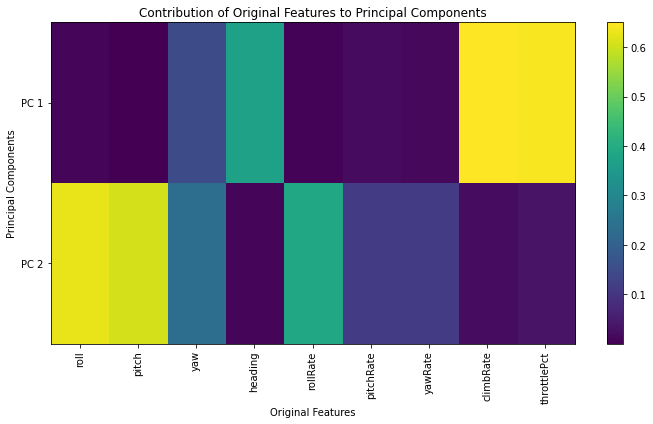

In [19]:
# Plot the contribution of original features to each principal component
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(pca.components_), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xticks(range(n_features), data_pca.columns.tolist(), rotation=90)
plt.yticks(range(len(pca.components_)), ['PC {}'.format(i+1) for i in range(len(pca.components_))])
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.title('Contribution of Original Features to Principal Components')
plt.tight_layout()
plt.show()

In [20]:
# seaborn.reset_defaults()

In [21]:
def markov_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

In [22]:
import numpy as np

def markov_distance_3d(x, y):
    return np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2)

In [23]:
normal_centroid = df_pca[df_pca['label'] == 'normal'].mean()

In [24]:
normal1_centroid = df_pca[df_pca['label'] == 'normal1'].mean()

In [25]:
normal1_centroid.values

array([2.69455954, 0.04285224])

In [26]:
df_pca['markov_distance'] = df_pca.apply(lambda row: markov_distance(normal_centroid.values, np.array([row['PC1'], row['PC2']])), axis=1)
df_pca['markov_distance1'] = df_pca.apply(lambda row: markov_distance(normal1_centroid.values, np.array([row['PC1'], row['PC2']])), axis=1)
# df_pca['markov_distance'] = df_pca.apply(lambda row: markov_distance(normal_centroid.values, np.array([row['PC1'], row['PC2'], row['PC3']])), axis=1)

In [27]:
distance = df_pca[df_pca['label'] == 'normal']['markov_distance'].max()
distance1 = df_pca[df_pca['label'] == 'normal1']['markov_distance1'].max()

In [28]:
# Calculate bounds for the rectangle
x_min = df_pca[df_pca['label'] == 'normal']['PC1'].min()
x_max = df_pca[df_pca['label'] == 'normal']['PC1'].max()
y_min = df_pca[df_pca['label'] == 'normal']['PC2'].min()
y_max = df_pca[df_pca['label'] == 'normal']['PC2'].max()

In [29]:
# Compute standard deviation for each column
statistics_dev = df_pca[df_pca['label'] == 'normal']

std_dev = statistics_dev.std()
mean_dev = statistics_dev.mean()

In [30]:
std_dev

PC1                 0.364599
PC2                 0.055499
markov_distance     0.222418
markov_distance1    0.363683
dtype: float64

In [36]:
def create_merged_circle(center1, radius1, center2, radius2, **kwargs):
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = center1[0] + radius1 * np.cos(theta)
    y1 = center1[1] + radius1 * np.sin(theta)
    x2 = center2[0] + radius2 * np.cos(theta)
    y2 = center2[1] + radius2 * np.sin(theta)
    verts = np.concatenate([np.column_stack([x1, y1]), np.column_stack([x2, y2][::-1])])
    path = Path(verts)
    return patches.PathPatch(path, **kwargs)

In [37]:
import matplotlib.patches as patches
from matplotlib.path import Path

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

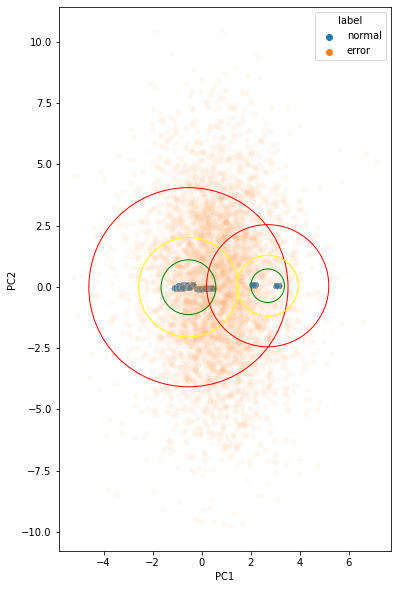

In [38]:
plot = df_pca.loc[df['tag'].isin(['normal', 'gaus','normal1'])].replace('normal1', 'normal').replace('gaus', 'error')
_, ax = plt.subplots(figsize=(10,10))


center = (normal_centroid.values[0], normal_centroid.values[1])
radius = distance + distance*0.1

circle = plt.Circle(center, radius, color='green', fill=False)
ax.add_patch(circle)

radius = distance *2
circle = plt.Circle(center, radius, color='yellow', fill=False)
ax.add_patch(circle)

radius = df_pca[df_pca['label'] == 'normal']['markov_distance'].max() *4
circle = plt.Circle(center, radius, color='red', fill=False)
ax.add_patch(circle)

center = (normal1_centroid.values[0], normal1_centroid.values[1])
radius = distance1  + distance1*0.1

circle = plt.Circle(center, radius, color='green', fill=False)
ax.add_patch(circle)

radius = distance1 *2
circle = plt.Circle(center, radius, color='yellow', fill=False)
ax.add_patch(circle)

radius = distance1 *4
circle = plt.Circle(center, radius, color='red', fill=False)
ax.add_patch(circle)

# plt.axvline(x=1)
ax.set_aspect('equal')

sns.scatterplot(data=plot, x='PC1', y='PC2', hue=plot['label'], alpha=0.04)

In [39]:
df_pca

PC1       PC2   label  markov_distance  markov_distance1
0     -0.584885  0.046886  normal         0.078357          3.279447
1     -0.584885  0.046886  normal         0.078357          3.279447
2     -0.584885  0.046886  normal         0.078357          3.279447
3     -0.584885  0.046886  normal         0.078357          3.279447
4     -0.584885  0.046886  normal         0.078357          3.279447
...         ...       ...     ...              ...               ...
43664  0.771202 -1.348391    gaus         1.868593          2.373787
43665  0.839683 -4.106424    gaus         4.315273          4.545004
43666  3.084412  3.425127    gaus         4.999755          3.404668
43667  0.102624  3.989727    gaus         4.059013          4.721859
43668  0.596283 -0.137922    gaus         1.143478          2.106049

[43669 rows x 5 columns]

In [40]:
df_pca.loc[(df_pca['markov_distance'] > distance*4) &
           (df_pca['markov_distance1'] > distance1*4), 'label'] = 'abnormal'
df_pca.loc[((df_pca['markov_distance'] > distance *2) & (df_pca['markov_distance'] <= distance *4)) |
           ((df_pca['markov_distance1'] > distance1 *2) & (df_pca['markov_distance1'] <= distance1 *4)), 'label'] = 'mild'
df_pca.loc[((df_pca['markov_distance'] > distance + distance*0.1) & (df_pca['markov_distance'] <= distance *2)) |
           ((df_pca['markov_distance1']> distance1+ distance1*0.1)& (df_pca['markov_distance1']<= distance1 *2)), 'label'] = 'noise'
df_pca.loc[(df_pca['markov_distance'] <= distance + distance*0.1 ) |
           (df_pca['markov_distance1']<= distance1+ distance1*0.1), 'label'] = 'normal'


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

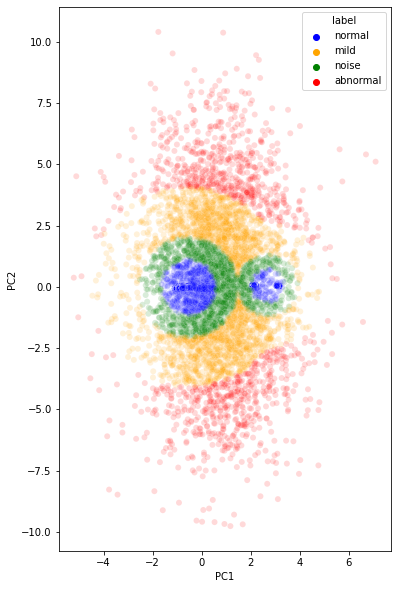

In [41]:
plot = df_pca.loc[df_pca['label'].isin(['noise', 'mild','normal', 'abnormal'])]
_, ax = plt.subplots(figsize=(15,10))
palette = {'normal': 'blue', 'noise': 'green', 'mild': 'orange', 'abnormal': 'red'}
# plt.axvline(x=1)
ax.set_aspect('equal')

sns.scatterplot(data=plot, x='PC1', y='PC2', hue=plot['label'], palette=palette, alpha=0.15)

# 3 - Decision tree

In [42]:
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import graphviz

In [43]:
data_pca

roll     pitch       yaw   heading  rollRate  pitchRate   yawRate  \
0     -0.003626 -0.005965 -0.290068 -0.242016 -0.002643   0.014308  0.004145   
1     -0.003626 -0.005965 -0.290068 -0.242016 -0.002643   0.014308  0.004145   
2     -0.003626 -0.005965 -0.290068 -0.242016 -0.002643   0.014308  0.004145   
3     -0.003626 -0.005965 -0.290068 -0.242016 -0.002643   0.014308  0.004145   
4     -0.003626 -0.005965 -0.290068 -0.242016 -0.002643   0.014308  0.004145   
...         ...       ...       ...       ...       ...        ...       ...   
43664 -3.249364 -3.863228  4.008863 -0.806861  0.360401   2.520983 -2.528447   
43665  1.776704 -3.736648  0.002733  1.657116  2.394533  -1.237790 -0.614874   
43666 -0.944085  3.572386  0.911917  1.628645 -2.434379   2.928333 -1.278834   
43667 -1.809321 -0.083356 -7.203642  1.630876 -1.974397  -0.848600 -2.956336   
43668  0.602263 -0.744029  3.244301 -0.757035 -2.645211  -1.949576 -1.447464   

       climbRate  throttlePct  
0       0.179472    -0.518308  
1       0.179472    -0.518308  
2       0.179472    -0.518308  
3       0.179472    -0.518308  
4       0.179472    -0.518308  
...          ...          ...  
43664   0.388461     1.182680  
43665   1.235426     1.567858  
43666   0.061522     3.825531  
43667   0.371025     1.319564  
43668   0.598890     1.213036  

[43669 rows x 9 columns]

In [44]:
X = data_pca.values
Y =  df_pca['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


clf = tree.DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9385161438058164
Precision: 0.9382311667278478
Recall: 0.9385161438058164
F1-score: 0.9383454400281173


In [45]:
X =  df.drop(columns=['id','Type', 'tag','error','heading','groundSpeed', 'altitudeRelative'])
Y =  df_pca['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


clf = tree.DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9410350354934738
Precision: 0.9410959657873458
Recall: 0.9410350354934738
F1-score: 0.9410251851420623


In [106]:
clf.predict([[2., 2., 2.,2.,2.,2.,2.,2.]])[0]

'abnormal'

In [108]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=data_pca.columns.tolist(),  
                      class_names=['normal','noise','mild', 'abnormal'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [109]:
graph.render("uav_values1") 

'uav_values1.pdf'

## PCA tree

In [42]:
df_pca.values

array([[-0.5848853941423287, 0.046885604179015244, 'normal',
        0.07835747671273127, 3.279447411739077],
       [-0.5848853941423287, 0.046885604179015244, 'normal',
        0.07835747671273127, 3.279447411739077],
       [-0.5848853941423287, 0.046885604179015244, 'normal',
        0.07835747671273127, 3.279447411739077],
       ...,
       [3.084412219834278, 3.4251268297107926, 'abnormal',
        4.999755031396047, 3.4046683382071703],
       [0.1026236006769207, 3.9897273008168925, 'mild',
        4.0590125482533175, 4.721859233463188],
       [0.5962831064523361, -0.13792165090950884, 'noise',
        1.1434775277189162, 2.1060491876998895]], dtype=object)

In [46]:
X = df_pca.drop(columns=['label', 'markov_distance', 'markov_distance1']).values
Y =  df_pca['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


clf = tree.DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9954201969315319
Precision: 0.9954201969315319
Recall: 0.9954201969315319
F1-score: 0.9954201969315319


In [47]:
from sklearn.tree import  plot_tree

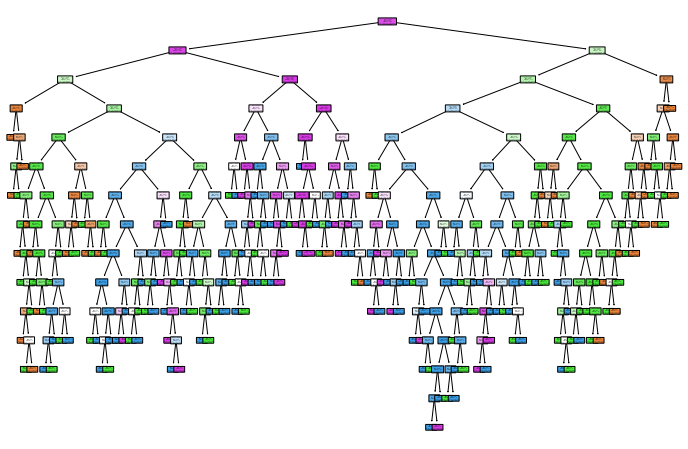

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size as needed
plot_tree(clf, filled=True, ax=ax, feature_names=df_pca.drop(columns=['label', 'markov_distance', 'markov_distance1']).columns.tolist(),  
                      class_names=['normal','noise','mild', 'abnormal'],  
                      rounded=True)

# Save the figure as a high-resolution PNG
fig.savefig('tree_output.png', dpi=1200) 

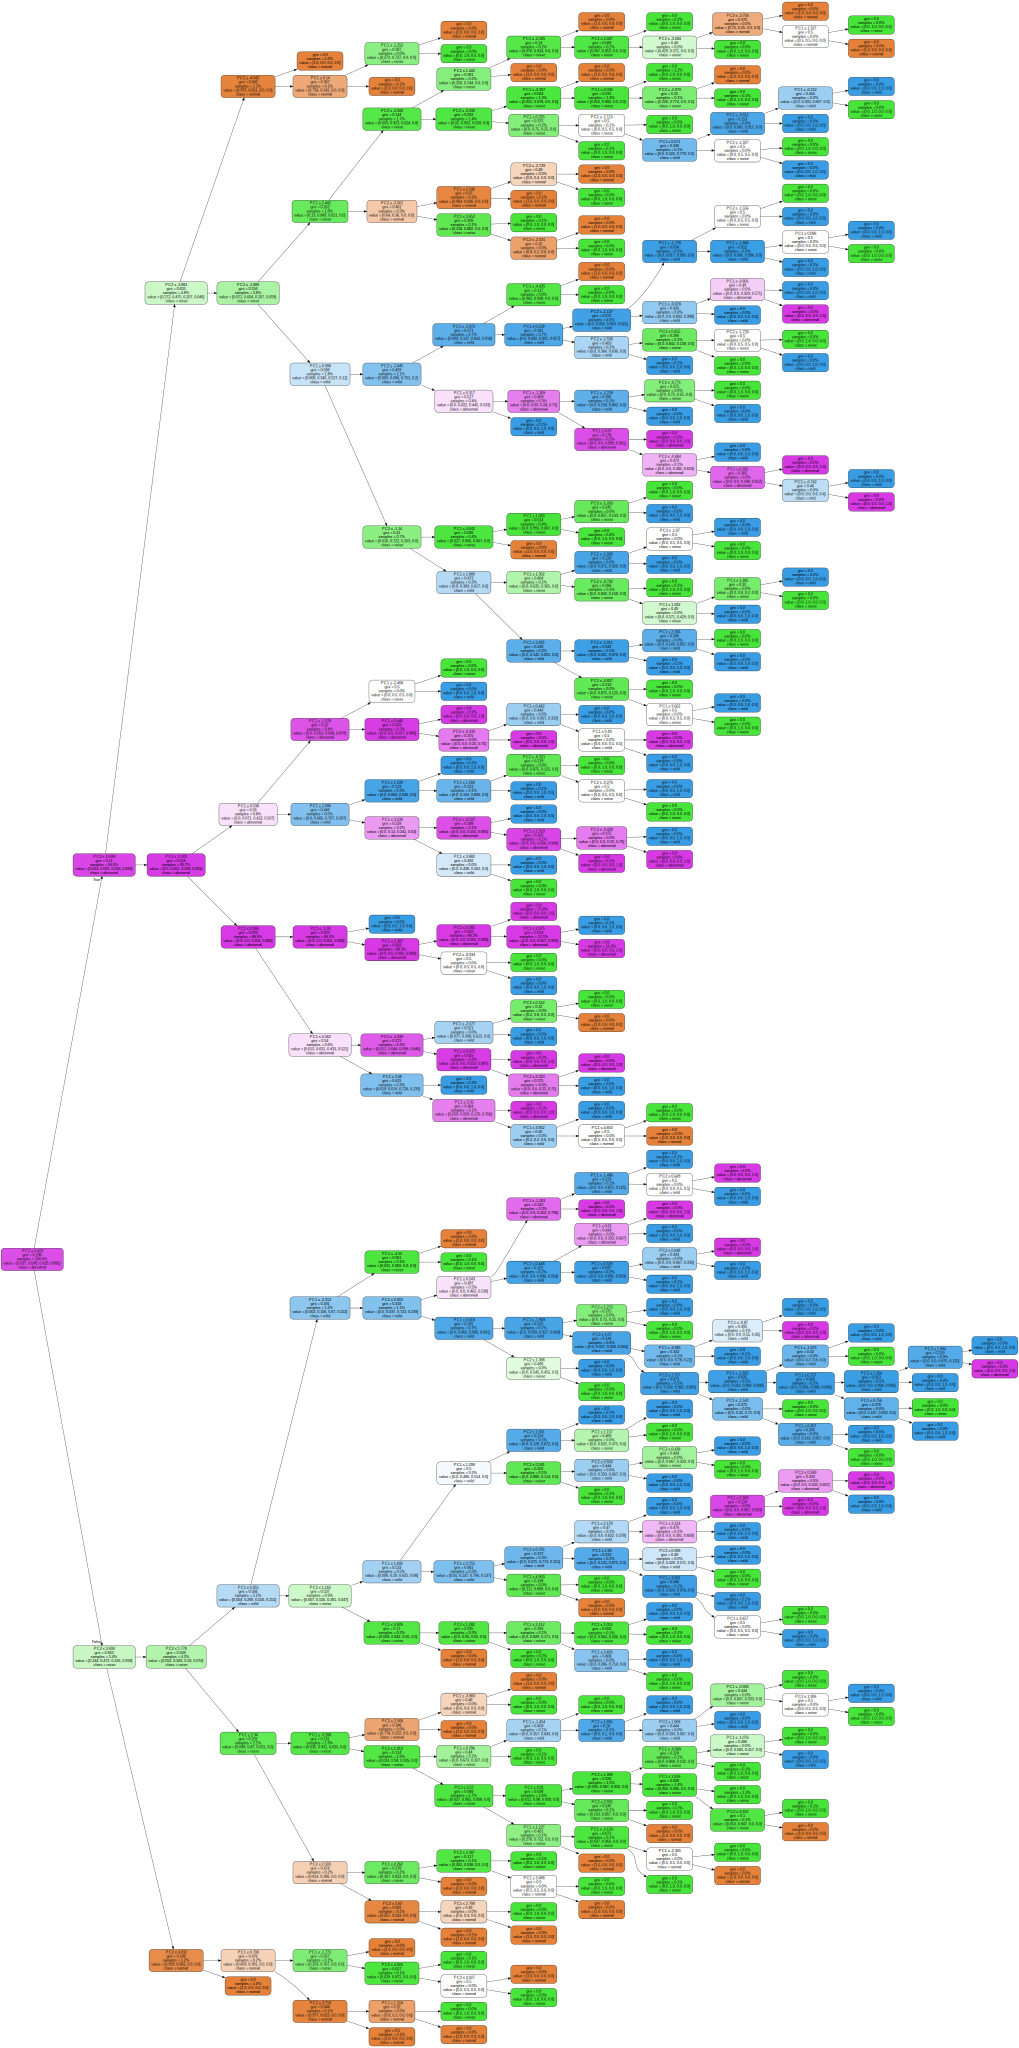

In [75]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=df_pca.drop(columns=['label', 'markov_distance', 'markov_distance1']).columns.tolist(),  
                      class_names=['normal','noise','mild', 'abnormal'],  
                      filled=True, rounded=True, rotate = True, proportion = True,
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [76]:
graph.render("PCA_values_alt1") 

'PCA_values_alt2.pdf'

# 2- Saving models

In [119]:
model_filename = "tree_pca_alt.pkl"
joblib.dump(clf, model_filename)

['tree_pca_alt.pkl']

In [120]:
model_filename = "pca_model_alt.pkl"
joblib.dump(pca, model_filename)

['pca_model_alt.pkl']

In [121]:
# Export the scaler model using joblib
scaler_filename = "scaler_model_alt.pkl"
joblib.dump(min_max_scaler, scaler_filename)

['scaler_model_alt.pkl']

In [122]:
loaded_pca = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

In [124]:
# Add a single new value
new_value = np.random.rand(1, 9)  # 1 sample, 5 features
scaled_new_value = loaded_scaler.transform(new_value)

print("Original data shape:", new_value)
print("Scaled new value shape:", scaled_new_value)

Original data shape: [[0.64320572 0.53319306 0.32260595 0.7832902  0.29883581 0.32786999
  0.5535871  0.87788645 0.43933626]]
Scaled new value shape: [[ 0.18520187  0.14583165 -0.18117279 -0.88878229  0.17101937  0.20194418
   0.32622469  2.09572694  0.74864736]]


In [125]:
pca_value = loaded_pca.transform(scaled_new_value)

print("Original data shape:", scaled_new_value)
print("Transformed new value shape:", pca_value)

Original data shape: [[ 0.18520187  0.14583165 -0.18117279 -0.88878229  0.17101937  0.20194418
   0.32622469  2.09572694  0.74864736]]
Transformed new value shape: [[-1.24014719 -0.11778689]]


In [126]:
pca_value

array([[-1.24014719, -0.11778689]])

In [127]:
pca_value[0][0]

-1.2401471855472994

In [128]:
new_value

array([[0.64320572, 0.53319306, 0.32260595, 0.7832902 , 0.29883581,
        0.32786999, 0.5535871 , 0.87788645, 0.43933626]])